# TODO: Split into multiple files

# Setup

First we need to import our audio to an array (as 32-bit floats).
We also initialize some things we'll need later.
The audio clip we'll be using can be found in [`audio/sample.wav`](../audio/sample.wav).
This sample was kindly provided by `thisisausername#0478`.

<ipython-input-1-889c0e11bdb8>:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, audio = read('../audio/sample.wav')


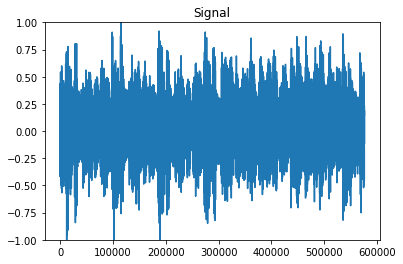

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
from ipywidgets.widgets import interact

# Read the audio sample as float32-array
samplerate, audio = read('../audio/sample.wav')

# Convert to mono for the sake of simplicity
audio = audio[::,0].astype(np.float32)
audio = audio / (np.max(audio) or 1)  # Set between -1 and 1

# plot audio
plt.ylim(-1, 1)
plt.title('Signal')
plt.plot(audio)
ipd.Audio(audio, rate=samplerate)

# Volume

The graph above shows the audio: The further away from 0, the louder it is.
As time moves on, the graph goes to the right.

To show this, we can lower the volume by dividing it:
> Note: The audio clip itself might not have a lower volume due to how IPython.display works

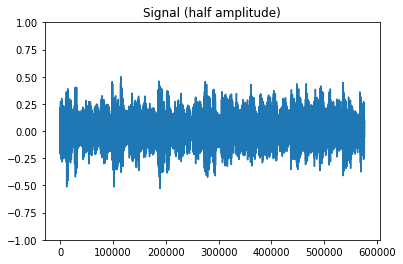

In [2]:
low_audio = audio / 2

plt.ylim(-1, 1)
plt.title('Signal (half amplitude)')
plt.plot(low_audio)
ipd.Audio(low_audio, rate=samplerate)

As you can see, the height of the graph is a lot lower, and as such the volume is lower.
It is important to note that volume is often expressed in decibels (dB), but we're working with amplitude.

You can use the following functions to convert between the two:

```python
def decibels_to_amplitude(db: float) -> float:
    return 10**(db / 20)

def amplitude_to_decibels(amp: float) -> float:
    return 20 * math.log(amp, 10)
```

---
For the next few examples, we'll need a small sample. Let's take 20ms of audio:

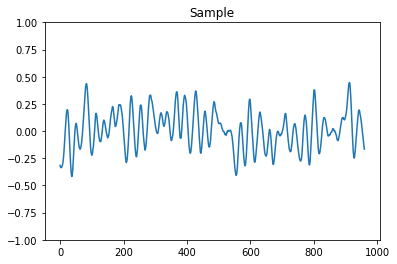

In [3]:
sample = audio[:int(samplerate*0.020)]
plt.ylim(-1, 1)
plt.title('Sample')
plt.plot(sample)

# FFT

Next, it would be a good idea to get the FFT results of this sample.
The FFT basically means we're looking at how much a frequency is present in the sample.

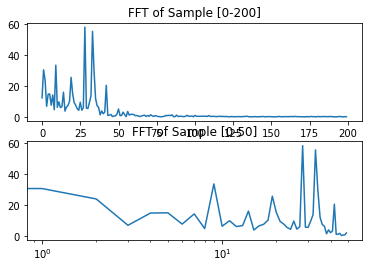

In [4]:
fft_result = np.fft.fft(sample)

# For FFT results, we only care about the first half.
fft_result = fft_result[:int(len(fft_result)/2)]

# The results are imaginary, so we turn them into real numbers:
fft_result = np.sqrt(fft_result.real**2 + fft_result.imag**2)

# For this sample there's not a lot of detail, so we're only displaying the first 200 items, as well as a figure with just 50 points
fig, axs = plt.subplots(2)
axs[0].set_title('FFT of Sample [0-200]')
axs[0].plot(fft_result[:200])
axs[1].set_title('FFT of Sample [0-50]')
axs[1].set_xscale('log')
axs[1].plot(fft_result[:50])

While this is nice to see, there's not a lot of detail in here.
To get more detail, we can add zeros to the end of the sample:

In [5]:
@interact(n=(1,8))
def pad(n):
    global fft_result

    # Make the sample N times as long by adding zeros
    sample_padded = np.append(sample, np.zeros(len(sample) * (n-1)))

    # Display FFT again
    fft_result = np.fft.fft(sample_padded)
    fft_result = fft_result[:int(len(fft_result)/2)]
    fft_result = np.sqrt(fft_result.real**2 + fft_result.imag**2)
    # Because the sample is 4x as big, we get 4x as many FFT points
    fig, axs = plt.subplots(2)
    axs[0].set_title(f'FFT of Sample [0-{200*n}]')
    axs[0].plot(fft_result[:200*n])
    axs[1].set_title(f'FFT of Sample [0-{50*n}]')
    axs[1].set_xscale('log')
    axs[1].plot(fft_result[:50*n])

interactive(children=(IntSlider(value=4, description='n', max=8, min=1), Output()), _dom_classes=('widget-inte…

That's a lot better already, and without much accuracy loss.
> There is *some* accuracy loss here, but I've been unable to find any details about how much this is.
> It's generally a good practice to only use a 4x sample at most.

The one odd thing about this is this: The FFT values are not per-frequency. Instead, they refer to groups of frequencies.

To get the size of a frequency group, simply divide the samplerate by the fft size

In [6]:
# We divided this by 2 earlier, now we multiply by 2 again to get the full size
# If you want to get the result after interacting with the slider above, re-run this block.
fft_size = len(fft_result) * 2
print(f"The size of each group is {samplerate/fft_size}Hz")

The size of each group is 12.5Hz


# Filters

Another commonly referenced term you'll see are Biquad filters.
These are simply functions like this:

$$ H(z)={\frac{b_{0}+b_{1}z^{{-1}}+b_{2}z^{{-2}}}{a_{0}+a_{1}z^{{-1}}+a_{2}z^{{-2}}}} $$

While this may seem very overwhelming at first, the code for it is quite simple.

```python
history = [0, 0]
new_history = [0, 0]

def apply(sample):
    new_sample = sample.copy()

    # The first two values are special since they need the old values
    # Coefficients (b0, b1, b2, a1 and a2) will be explained later
    new_sample[0] = (b0 * sample[0]
                     + b1 * history[1]
                     + b2 * history[0]
                     - a1 * new_history[1]
                     - a2 * new_history[0])
    new_sample[1] = (b0 * sample[1]
                     + b1 * sample[0]
                     + b2 * history[1]
                     - a1 * new_sample[0]
                     - a2 * new_history[1])

    for x in range(2, len(sample)):
        new_sample[x] = (b0 * sample[x]
                         + b1 * sample[x-1]
                         + b2 * sample[x-2]
                         - a1 * new_sample[x-1]
                         - a2 * new_sample[x-2])

    history[0] = sample[-2]
    history[1] = sample[-1]
    new_history[0] = new_sample[-2]
    new_history[1] = new_sample[-1]

    return new_sample
```

Below you can experiment with the coefficients

In [7]:
@interact(b0=(-1.0, 1.0, 0.05),
          b1=(-1.0, 1.0, 0.05),
          b2=(-1.0, 1.0, 0.05),
          a1=(-1.0, 1.0, 0.05),
          a2=(-1.0, 1.0, 0.05))
def render(b0, b1, b2, a1, a2):
    history = [0, 0]
    new_history = [0, 0]

    def apply(sample):
        new_sample = sample.copy()

        # The first two values are special since they need the old values
        # Coefficients (b0, b1, b2, a1 and a2) will be explained later
        new_sample[0] = (b0 * sample[0]
                         + b1 * history[1]
                         + b2 * history[0]
                         - a1 * new_history[1]
                         - a2 * new_history[0])
        new_sample[1] = (b0 * sample[1]
                         + b1 * sample[0]
                         + b2 * history[1]
                         - a1 * new_sample[0]
                         - a2 * new_history[1])

        for x in range(2, len(sample)):
            new_sample[x] = (b0 * sample[x]
                             + b1 * sample[x-1]
                             + b2 * sample[x-2]
                             - a1 * new_sample[x-1]
                             - a2 * new_sample[x-2])

        history[0] = sample[-2]
        history[1] = sample[-1]
        new_history[0] = new_sample[-2]
        new_history[1] = new_sample[-1]
        return new_sample

    # Get an impulse sample
    samp = np.zeros(int(samplerate*0.020))
    samp[0] = 1.0

    result = apply(samp)
    fft_result = np.fft.fft(result)
    fft_result = fft_result[:int(len(fft_result)/2)]
    fft_result = np.sqrt(fft_result.real**2 + fft_result.imag**2)

    fig, axs = plt.subplots(2)
    axs[0].set_title('Response')
    axs[0].plot(result)
    axs[1].set_title('FFT of Response')
    axs[1].set_xscale('log')
    axs[1].plot(fft_result)

interactive(children=(FloatSlider(value=0.0, description='b0', max=1.0, min=-1.0, step=0.05), FloatSlider(valu…

These coefficients are usually a bit of magic numbers, and there's little documentation on why they're calculated as they are.
Below is an interactive demo for how to calculate them.

In [ ]:
import math

@interact(type_filter=["lowpass", "highpass", "bandpass"], 
          frequency=(1, 20000, 1),
          quality=(0.01, 4.0, 0.01))
def showFromFreq(type_filter, frequency, quality):
    # Magic variables
    print("""
factor_k = math.tan(math.pi * (frequency / samplerate))
factor_k_square = factor_k**2
norm = 1.0 / (1.0 + factor_k / quality + factor_k_square)
    """.strip())
    
    factor_k = math.tan(math.pi * (frequency / samplerate))
    factor_k_square = factor_k**2
    norm = 1.0 / (1.0 + factor_k / quality + factor_k_square)
    
    if (type_filter == "lowpass"):
        print("""
a1 = 2.0 * (factor_k_square - 1.0) * norm
a2 = (1.0 - factor_k / quality + factor_k_square) * norm
b0 = factor_k_square * norm
b1 = 2.0 * factor_k_square * norm
b2 = factor_k_square * norm
        """.strip())
        
        a1 = 2.0 * (factor_k_square - 1.0) * norm
        a2 = (1.0 - factor_k / quality + factor_k_square) * norm
        b0 = factor_k_square * norm
        b1 = 2.0 * factor_k_square * norm
        b2 = factor_k_square * norm
    elif (type_filter == "highpass"):
        print("""
a1 = 2.0 * (factor_k_square - 1.0) * norm
a2 = (1.0 - factor_k / quality + factor_k_square) * norm
b0 = norm
b1 = -2.0 * norm
b2 = norm
        """.strip())
        
        a1 = 2.0 * (factor_k_square - 1.0) * norm
        a2 = (1.0 - factor_k / quality + factor_k_square) * norm
        b0 = norm
        b1 = -2.0 * norm
        b2 = norm
    elif (type_filter == "bandpass"):
        print("""
a1 = 2.0 * (factor_k_square - 1.0) * norm
a2 = (1.0 - factor_k / quality + factor_k_square) * norm
b0 = factor_k / quality * norm
b1 = 0.0
b2 = -factor_k / quality * norm
        """.strip())
        
        a1 = 2.0 * (factor_k_square - 1.0) * norm
        a2 = (1.0 - factor_k / quality + factor_k_square) * norm
        b0 = factor_k / quality * norm
        b1 = 0.0
        b2 = -factor_k / quality * norm
    
    # Code below is just rendering
    history = [0, 0]
    new_history = [0, 0]

    def apply(sample):
        new_sample = sample.copy()

        # The first two values are special since they need the old values
        # Coefficients (b0, b1, b2, a1 and a2) will be explained later
        new_sample[0] = (b0 * sample[0]
                         + b1 * history[1]
                         + b2 * history[0]
                         - a1 * new_history[1]
                         - a2 * new_history[0])
        new_sample[1] = (b0 * sample[1]
                         + b1 * sample[0]
                         + b2 * history[1]
                         - a1 * new_sample[0]
                         - a2 * new_history[1])

        for x in range(2, len(sample)):
            new_sample[x] = (b0 * sample[x]
                             + b1 * sample[x-1]
                             + b2 * sample[x-2]
                             - a1 * new_sample[x-1]
                             - a2 * new_sample[x-2])

        history[0] = sample[-2]
        history[1] = sample[-1]
        new_history[0] = new_sample[-2]
        new_history[1] = new_sample[-1]
        return new_sample

    # Get an impulse sample
    samp = np.zeros(int(samplerate*0.020))
    samp[0] = 1.0

    result = apply(samp)
    fft_result = np.fft.fft(result)
    fft_result = fft_result[:int(len(fft_result)/2)]
    fft_result = np.sqrt(fft_result.real**2 + fft_result.imag**2)

    fig, axs = plt.subplots(2)
    axs[0].set_title('Response')
    axs[0].plot(result)
    axs[1].set_title('FFT of Response')
    axs[1].set_xscale('log')
    axs[1].plot(fft_result)